In [65]:
import sys
sys.path.append('../src/')
import torch
import pandas as pd
import numpy as np
import pickle
import argparse
import networkx as nx
from torch_geometric.utils import dense_to_sparse, degree
import matplotlib.pyplot as plt
from utils.classificationnet import GCNSynthetic
from utils.utils import normalize_adj, get_neighbourhood
import seaborn as sns
sns.set_style("whitegrid")
sns.set(font_scale = 2.5)

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
torch.set_printoptions(precision=8)
header = ["node_idx", "new_idx", "cf_adj", "sub_adj", "cf", "num_nodes", "node_dict", "y_pred", "y_pred_cf",
            "label",  "loss_total", "loss_pred", "loss_graph_dist", "found"]

save_prefix:
1. syn4:
    * inductive: inductive_non0_correct_only
    * transductive: transductive_non0_correct_only
2. syn5:
    * inductive: ablation_feats_entropy
    * transductive: transductive_non0_correct_only
3. syn1:
    * inductive: ablation_feats_degree
    * transductive: transductive_non0_correct_only

In [68]:
dataset = "syn5"
data_dict = {'syn4': 'Tree-Cycles', 'syn5':'Tree-Grid', 'syn1':'BA-Shapes'}

In [69]:
save_prefix = 'transductive_non0_correct_only' 

In [70]:
inductive = False  if "transductive" in save_prefix else True
print(inductive)

False


In [71]:
# Load cf examples for train set
if(inductive):
    with open("../results/{}/{}_train_{}.pkl".format(dataset, dataset, save_prefix), "rb") as ftrain:
        cf_examples_train = pickle.load(ftrain)
    ftrain.close()


    # Load cf examples for test set
    with open("../results/{}/{}_test_{}.pkl".format(dataset, dataset, save_prefix), "rb") as ftest:
        cf_examples_test = pickle.load(ftest)
    ftest.close()
else:
    # Load cf examples for train set
    with open("../results/{}/{}_{}.pkl".format(dataset, dataset, save_prefix), "rb") as ftrain:
        cf_examples_train = pickle.load(ftrain)
    ftrain.close()

In [72]:
df_train = pd.DataFrame(columns=header)
df_train_not_found = pd.DataFrame(columns=header)

for key in cf_examples_train.keys():
    val={}
    i=0
    for head in header:
        if(head == "node_idx"):
            val[head] = key
        else:
            if(torch.is_tensor(cf_examples_train[key][i])):
                val[head] = cf_examples_train[key][i].detach().cpu().numpy()
            else:
                val[head] = cf_examples_train[key][i]
            i+=1
    if(val['found'] == 'not found'):
        df_train_not_found = df_train_not_found.append(val, ignore_index=True)
    else:
        df_train = df_train.append(val, ignore_index=True)

print(len(df_train), len(df_train_not_found))

129 0


In [73]:
if(inductive):
    df_test = pd.DataFrame(columns=header)
    df_test_not_found = pd.DataFrame(columns=header)
    for key in cf_examples_test.keys():
        val={}
        i=0
        for head in header:
            if(head == "node_idx"):
                val[head] = key
            else:
                if(torch.is_tensor(cf_examples_test[key][i])):
                    val[head] = cf_examples_test[key][i].detach().cpu().numpy()
                else:
                    val[head] = cf_examples_test[key][i]
                i+=1
        if(val['found'] == 'not found'):
            df_test_not_found = df_test_not_found.append(val, ignore_index=True)
        else:
            df_test = df_test.append(val, ignore_index=True)

    print(len(df_test), len(df_test_not_found))


COMPUTING SIZE LIST

In [74]:
cf_size_list_train = []
cf_size_dict_train = {}
for i in range(len(df_train)) :
    cf = df_train.loc[i, "cf"]
    cf_len = len(cf)
    cf_size_list_train.append(cf_len)
    add=0
    deletion=0
    for j in range(cf_len):
        if(cf[j][2] == 'add'):
            add+=1
        else:
            deletion+=1

    if(cf_len not in cf_size_dict_train.keys()):
        cf_size_dict_train[cf_len] = {'num':1, 'add':add, 'del':deletion}
    else:
        cf_size_dict_train[cf_len]['add'] += add
        cf_size_dict_train[cf_len]['del'] += deletion
        cf_size_dict_train[cf_len]['num'] += 1

print('------------------\n')  
print(cf_size_dict_train)  

------------------

{1: {'num': 127, 'add': 99, 'del': 28}, 2: {'num': 2, 'add': 2, 'del': 2}}


In [75]:
if(inductive):
    cf_size_list_test = []
    cf_size_dict_test = {}
    for i in range(len(df_test)) :
        cf = df_test.loc[i, "cf"]
        cf_len = len(cf)
        cf_size_list_test.append(cf_len)
        add=0
        deletion=0
        for j in range(cf_len):
            if(cf[j][2] == 'add'):
                add+=1
            else:
                deletion+=1

        if(cf_len not in cf_size_dict_test.keys()):
            cf_size_dict_test[cf_len] = {'num':1, 'add':add, 'del':deletion}
        else:
            cf_size_dict_test[cf_len]['add'] += add
            cf_size_dict_test[cf_len]['del'] += deletion
            cf_size_dict_test[cf_len]['num'] += 1

    print('------------------\n')  
    print(cf_size_dict_test)  

In [76]:
cf_size_dict_train = dict(sorted(cf_size_dict_train.items() ,  key=lambda x: x[0]))
if(inductive):
    cf_size_dict_test = dict(sorted(cf_size_dict_test.items() ,  key=lambda x: x[0]))

PLOT HISTOGRAM

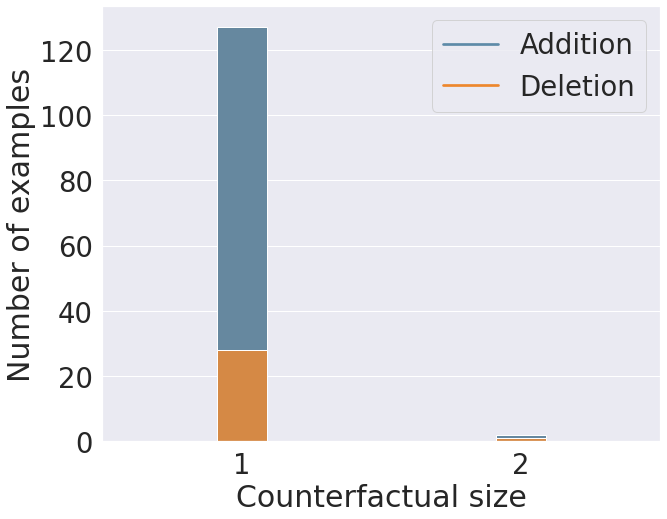

In [82]:
adds = []
deletions = []
freq = []
freq_add = []
freq_del = []
size = []
for key in cf_size_dict_train.keys():
    adds.append(cf_size_dict_train[key]['add'])
    deletions.append(cf_size_dict_train[key]['del'])
    freq.append(cf_size_dict_train[key]['num'])
    add_ratio = cf_size_dict_train[key]['add']/(cf_size_dict_train[key]['add'] + cf_size_dict_train[key]['del'])
    del_ratio = cf_size_dict_train[key]['del']/(cf_size_dict_train[key]['add'] + cf_size_dict_train[key]['del'])
    freq_add.append(cf_size_dict_train[key]['num']*add_ratio)
    freq_del.append(cf_size_dict_train[key]['num']*del_ratio)
    size.append(key)

# print(freq)
# print(freq_add)
# print(freq_del)
fig = plt.subplots(figsize =(10, 8))
ax = sns.barplot(x=size, y=freq, color='#5d8aa8')
ax = sns.barplot(x=size, y=freq_del, color='#ed872d')
plt.legend(loc='upper right', labels=['Addition', 'Deletion'])
leg = ax.get_legend()
leg.legendHandles[0].set_color('#5d8aa8')
leg.legendHandles[1].set_color('#ed872d')
plt.xlabel('Counterfactual size')
plt.ylabel('Number of examples')
# plt.title('Number of examples vs counterfactual size: {}'.format(data_dict[dataset]))
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .18)
plt.savefig(f'./{dataset}/{save_prefix}_bar_plot_train.pdf', bbox_inches='tight')

In [81]:
if(inductive):
    adds = []
    deletions = []
    freq = []
    freq_add = []
    freq_del = []
    size = []
    for key in cf_size_dict_test.keys():
        adds.append(cf_size_dict_test[key]['add'])
        deletions.append(cf_size_dict_test[key]['del'])
        freq.append(cf_size_dict_test[key]['num'])
        add_ratio = cf_size_dict_test[key]['add']/(cf_size_dict_test[key]['add'] + cf_size_dict_test[key]['del'])
        del_ratio = cf_size_dict_test[key]['del']/(cf_size_dict_test[key]['add'] + cf_size_dict_test[key]['del'])
        freq_add.append(cf_size_dict_test[key]['num']*add_ratio)
        freq_del.append(cf_size_dict_test[key]['num']*del_ratio)
        size.append(key)
        
    fig = plt.subplots(figsize =(10, 8))
    # creating subplots
    # plotting columns
    ax = sns.barplot(x=size, y=freq, color='#5d8aa8', dodge=False)
    ax = sns.barplot(x=size, y=freq_del, color='#ed872d', dodge=False)
    plt.legend(loc='upper right', labels=['Addition', 'Deletion'])
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('#5d8aa8')
    leg.legendHandles[1].set_color('#ed872d')
    plt.xlabel('Counterfactual size')
    plt.ylabel('Number of examples')
    # plt.title('Number of examples vs counterfactual size: {}'.format(data_dict[dataset]))
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    change_width(ax, .2)
    plt.savefig(f'./{dataset}/{save_prefix}_bar_plot_test.pdf', bbox_inches='tight')